# Importing the necessary packages

In [42]:
from __future__ import print_function
import keras
import keras.utils
from keras.models import Model
from keras.layers import Input, LSTM, Dense

import numpy as np

Providing the necessary parameters

In [43]:
batch_size = 55  # Batch size for training.
epochs = 39  # Number of epochs to train for.
latent_dim = 128  # Latent dimensionality of the encoding space.
num_samples = 15000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

Vectorize the data

In [44]:
 
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 15000
Number of unique input tokens: 73
Number of unique output tokens: 99
Max sequence length for inputs: 17
Max sequence length for outputs: 59


In [45]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

structuring the encoder and decoder

In [46]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [47]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Applying LSTM to the encoder and defining it's output

In [48]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Applying LSTM to the decoder and defining it's output

In [49]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Structuring the encoder-decoder model

In [50]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [53]:
# Run training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.6)
# Save model
model.save('s2s.h5')

Train on 6000 samples, validate on 9000 samples
Epoch 1/39
6000/6000 [==============================] - 18s 3ms/step - loss: 0.3854 - acc: 0.1964 - val_loss: 0.5729 - val_acc: 0.2051
Epoch 2/39
6000/6000 [==============================] - 16s 3ms/step - loss: 0.3750 - acc: 0.1988 - val_loss: 0.5684 - val_acc: 0.2059
Epoch 3/39
6000/6000 [==============================] - 17s 3ms/step - loss: 0.3689 - acc: 0.2005 - val_loss: 0.5615 - val_acc: 0.2077
Epoch 4/39
6000/6000 [==============================] - 16s 3ms/step - loss: 0.3626 - acc: 0.2022 - val_loss: 0.5586 - val_acc: 0.2080
Epoch 5/39
6000/6000 [==============================] - 16s 3ms/step - loss: 0.3580 - acc: 0.2031 - val_loss: 0.5551 - val_acc: 0.2096
Epoch 6/39
6000/6000 [==============================] - 16s 3ms/step - loss: 0.3526 - acc: 0.2049 - val_loss: 0.5511 - val_acc: 0.2109
Epoch 7/39
6000/6000 [==============================] - 16s 3ms/step - loss: 0.3476 - acc: 0.2059 - val_loss: 0.5476 - val_acc: 0.2120
Epoch 8

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/topology.py:2368: UserWarning: Layer lstm_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_7/while/Exit_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'lstm_7/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [54]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)


In [55]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [56]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [57]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [58]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Pours !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Wow!
Decoded sentence: Dégagne-moi !

-
Input sentence: Fire!
Decoded sentence: Soirris !

-
Input sentence: Help!
Decoded sentence: Arrique !

-
Input sentence: Jump.
Decoded sentence: Suige.

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Va de chez !

-
Input sentence: Go on.
Decoded sentence: Va de chez !

-
Input sentence: Go on.
Decoded sentence: Va de chez !

-
Input sentence: I see.
Decoded sentence: Je vois semmer.

-
Input sentence: I try.
Decoded sentence: Je l'ai essayé.

-
Input sentence: I won!
Decoded sentence: Je me suis mien.

-
Input sentence: I 

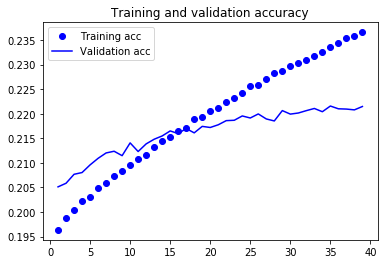

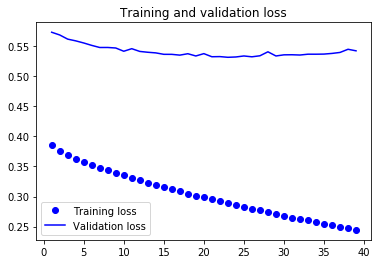

In [59]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


Reference : https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/